# Results Exploration

In [1]:
import sys
sys.path.append('./../src/')

import os
import ioutil

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

%matplotlib inline

In [2]:
ref_feature_dir = './../../data/to_analysis'
ref_results_dir = './../../data/outputs/model_comparison'

In [3]:
filter_cats = [
    label for label in os.listdir(ref_feature_dir)
    if not label.endswith('.csv') and not label.startswith('.')
]
df_y = np.squeeze(
    pd.read_csv('./../../data/to_analysis/target.csv', index_col=0).values
)

In [4]:
results = {}
for filter_cat in filter_cats:

    path_filter_cat_feature_sets = ioutil.relative_paths(
        os.path.join(ref_feature_dir, filter_cat), target_format='.csv'
    )
    results[filter_cat] = []
    for num, path_feature_set in enumerate(path_filter_cat_feature_sets):
        
        try:
            path_results = os.path.join(
                ref_results_dir, filter_cat, os.path.basename(path_feature_set)
            )
            results[filter_cat].append(pd.read_csv(path_results, index_col=0))
        except:
            pass

## Optimal discretization level and filter type
* Heat map of discretizatin levels and filter types based on he absolute max score from each level (no matter what algorithm aso.).

In [38]:
num_filters = 18
num_graylevels = 25
img_prep_results = np.zeros((num_filters, num_graylevels), dtype=float)

for filter_num, (filter_label, exp_results) in enumerate(results.items()):
    for discr_num, exp_result in enumerate(exp_results):
        # Compute mean performance of all models and select the 
        # absolute maximum as representative for filter and discr level combo.
        model_perf = exp_result.groupby('model').mean()['avg_test_score']
        img_prep_results[filter_num, discr_num] = np.max(model_perf.values)

In [39]:
bins = np.linspace(30, 130, 4, dtype=int)

discr_labels = []
for ct_bins in np.append(bins, 256):
    for pet_bins in np.append(bins, 512):
        discr_labels.append('CT{} | PET{}'.format(ct_bins, pet_bins))
discr_labels[:5]

['CT30 | PET30',
 'CT30 | PET63',
 'CT30 | PET96',
 'CT30 | PET130',
 'CT30 | PET512']

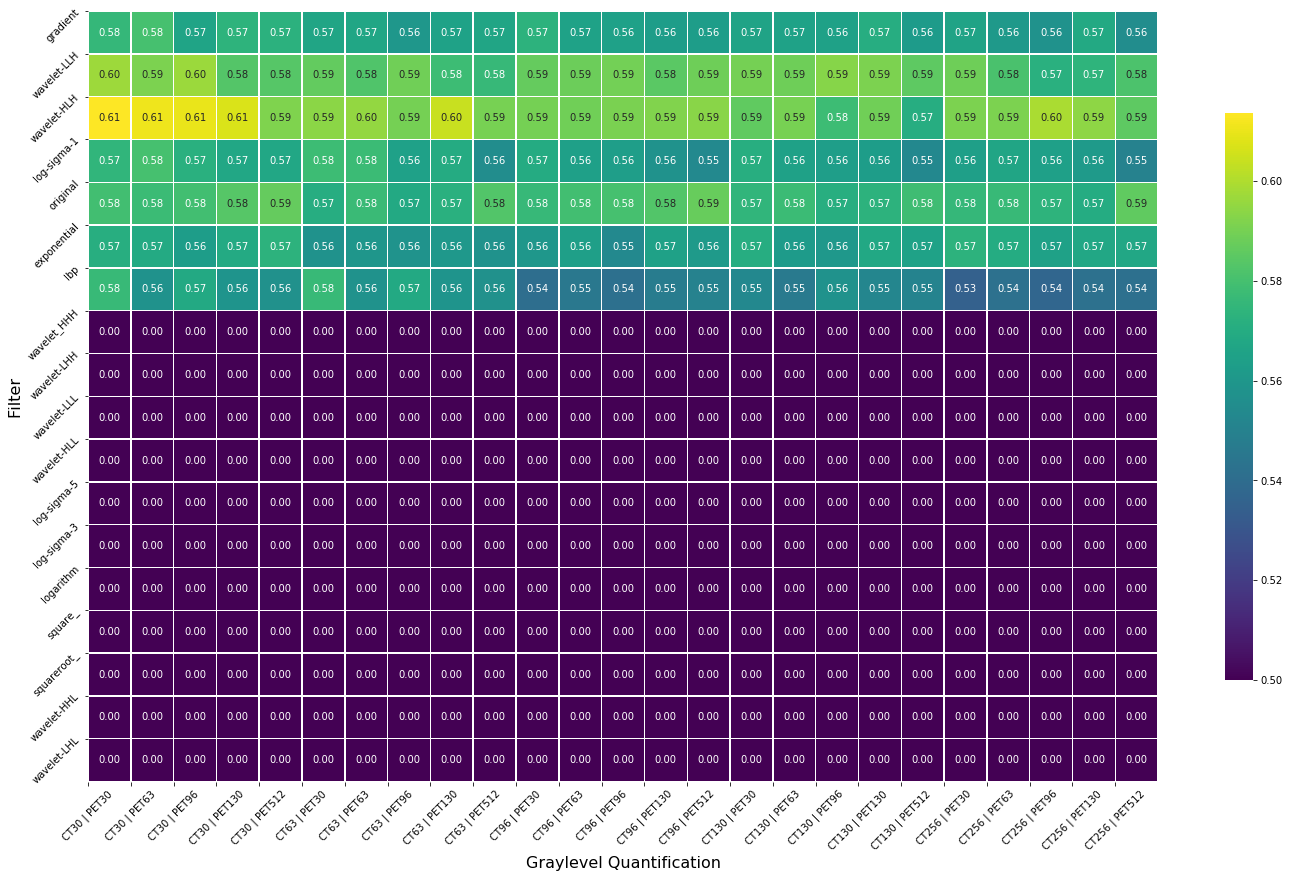

In [51]:
plt.figure(figsize=(20, 20))
ax = sns.heatmap(
    img_prep_results, 
    vmin=0.5, #np.min(img_prep_results), 
    vmax=np.max(img_prep_results),
    cmap=plt.cm.viridis,
    annot=True, fmt = '.2f', square=1, linewidth=.5, cbar=True,
    cbar_kws={'shrink': 0.5}, 
    #annot_kws={'size': 10}
)
#plt.axis('off')
plt.ylabel('Filter', fontsize=16)
plt.xlabel('Graylevel Quantification', fontsize=16)

plt.yticks(
    np.arange(len(results.keys())), results.keys(), rotation='45'
)
plt.xticks(
    np.arange(np.size(discr_labels)), discr_labels, rotation='45'
)
for num, value in enumerate(ax.texts): 
    #value.set_text('{} +/- {}'.format(value.get_text(), std_labels.ravel()[num]))
    value.set_text('{}'.format(value.get_text()))
plt.tight_layout()

## Optimal classifier and feature selector

In [61]:
# NOTE: A list with all 25 diff discr/filter combos.
best_filter = results['wavelet-HLH']
best_result = best_filter[0]

num_models, num_fs = 8, 7
avg_scores = np.zeros((num_models, num_fs), dtype=float)
std_scores = np.zeros((num_models, num_fs), dtype=float)

models = best_result.groupby('model')
for model_num, (model_name, model) in enumerate(models):
    
    selectors = model.groupby('selector')
    for fs_num, (fs_name, selector) in enumerate(selectors):
        
        avg_scores[model_num, fs_num] = np.mean(selector['avg_test_score'])
        std_scores[model_num, fs_num] = np.std(selector['avg_test_score'])

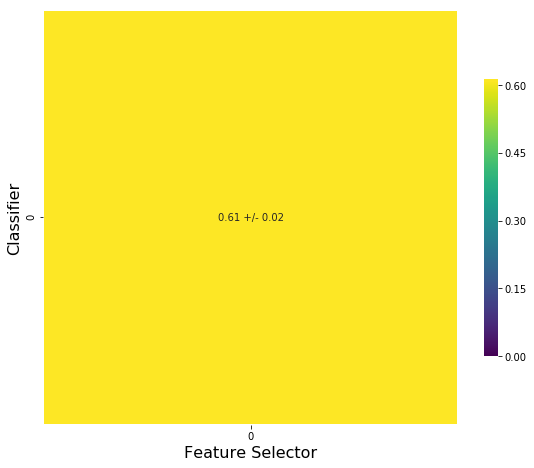

In [70]:
plt.figure(figsize=(8, 8))
ax = sns.heatmap(
    avg_scores, 
    vmin=np.min(img_prep_results), 
    vmax=np.max(img_prep_results),
    cmap=plt.cm.viridis,
    annot=True, fmt = '.2f', square=1, linewidth=.5, cbar=True,
    cbar_kws={'shrink': 0.5}, 
    #annot_kws={'size': 10}
)
#plt.axis('off')
plt.ylabel('Classifier', fontsize=16)
plt.xlabel('Feature Selector', fontsize=16)

#plt.yticks(
#    np.arange(len(results.keys())), results.keys(), rotation='45'
#)
#plt.xticks(
#    np.arange(np.size(discr_labels)), discr_labels, rotation='45'
#)
for num, value in enumerate(ax.texts): 
    value.set_text('{} +/- {}'.format(
        value.get_text(), np.round(std_scores.ravel()[num], decimals=2)
    ))
plt.tight_layout()

In [41]:
# Collect filter labels
filter_labels = []
for raw_label in os.listdir(ref_results_dir):
    
    if not raw_label.startswith('.'):
        
        label = raw_label.title().strip('_')
        if 'Wavelet' in label:
            name, levels = label.split('-')
            label = ('-').join((name, levels.upper()))
            
        if 'Lbp' in label:
            label = label.upper()
        
        filter_labels.append(label)
    
nbins = np.linspace(30, 130, 4, dtype=int)
# Create labels  filter name / (CT_nbins \mid PET_nbins)
img_combo_lbs = []
for ct_bins in nbins:
    for pet_bins in nbins:
        img_combo_lbs.append('CT_{} | PET_{}'.format(ct_bins, pet_bins))

setting_labels = []
for filter_label in filter_labels:
    for img_combo in img_combo_lbs:
        setting_labels.append(
            '{}\n{}\n{}'.format(filter_label, '-' * 15, img_combo)
        )
len(setting_labels)

288

In [8]:
def path_to_labels(path_to_file):
    
    if not path_to_file.startswith('.'):
        base_fname = os.path.basename(path_to_file)
        fname, _ = base_fname.split('.')
        ct_lvl, pet_lvl, _ = fname.split('_')
        return ('_').join((ct_lvl, pet_lvl))
    else:
        return None

In [9]:
axis2_labels = []
for path_name in os.listdir(os.path.join(ref_results_dir, axis1_labels[0])):
    label = path_to_labels(path_name)
    if label is not None:
        axis2_labels.append(label)

NameError: name 'axis1_labels' is not defined

In [ ]:
axis2_labels[:3]

In [ ]:
models = np.unique(results['gradient'][0]['model'])
selectors = np.unique(results['gradient'][0]['selector'])
axis3_labels = pd.MultiIndex.from_product(
    (models, selectors), names=('classifier', 'feature selector')
)
axis3_labels

In [ ]:
x = np.arange(np.size(axis2_labels), dtype=int)
y = np.arange(np.size(axis1_labels), dtype=int)

X, Y = np.meshgrid(x, y)

In [ ]:
fig = plt.figure(figsize=(10, 10))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.gca(projection='3d')

for filter_num, (filter_lbl, values) in enumerate(results.items()):

    z_axis = [filter_num]
    y_axis = np.arange(np.size(axis2_labels), dtype=int)
    
    # NB: Needs modifications to multiple models and selectors.
    # Collect average results of each model and selector pair.
    glob_results = [img_combo.mean()[0] for img_combo in values]
    
    if len(glob_results) > 0:
        ax.scatter(glob_results, y_axis, z_axis, c='b')#, c=c, marker=m)

#ax.set_xlabel(r'Classifier $\mid$ Feature Selector')
#ax.set_ylabel('Image Type')
#ax.set_zlabel('Filter')

ax.set_xticklabels(models)
ax.set_yticklabels(axis2_labels)
ax.set_zticklabels(axis1_labels)

plt.savefig(
    './../../../tm_mainres.png', transparent=True
)

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

n = 100

for c, m, zlow, zhigh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
    xs = np.random.random(n)
    ys = np.random.random(n)
    zs = [2]#np.random.random(n)
    ax.scatter(xs, ys, zs, c=c, marker=m)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

In [ ]:
n = 20
vmin = 0
vmax = 20
(vmax - vmin)*np.random.rand(n) + vmin

In [ ]:

img = np.random.random((256, 7 * 5))

plt.figure(figsize=(8, 8))
sns.heatmap(img)